## VK Visual Insights

### Описание проекта

В эпоху цифровизации традиционные методы изучения аудитории оффлайн мероприятий — онлайн-регистрация, подписки, анкетирование — всё чаще **дают искажённую картину**:

* Люди подписаны на группу, но давно отключили уведомления и не участвуют в жизни сообщества.
* В интернете много "мусора" - **ботов**, фейковых или неактивных аккаунтов.
* Многие участники мероприятий **не зарегистрированы в соцсети**, но активно участвуют оффлайн.
* При разовых мероприятиях — пользователь может появиться на один день и **не оставить цифрового следа**.

Таким образом, **реальная аудитория** мероприятия остаётся вне поля зрения.

---

**Почему именно фото + цифровой след?**

Мы предлагаем альтернативный способ получить **актуальную информацию** о посетителях мероприятия — это **анализ фотографий** с помощью нейросетей и сопоставление их с **цифровым следом** в соцсетях.

* Фото с мероприятий фиксируют **факт реального присутствия** — в отличие от регистрации или лайка.
* Компьютерное зрение позволяет **распознать пол, возраст, эмоции** — давая представление о настоящей, а не номинальной аудитории.
* Цифровой след (посты, комментарии, сторис) отражает **эмоциональную реакцию, интересы и вовлечённость**.

---

**Почему важно анализировать в динамике?**

Если мероприятие проводится ежегодно, можно изучить:

* Как **меняется состав аудитории** (молодеет/стареет, становится более мужским/женским).
* Как меняется **вовлечённость в постах и репостах**.
* Какие **темы и эмоции** преобладают в разное время.
* И главное — как это соотносится с реальными людьми, попавшими на фото.

---

**Что делает VK Visual Insights?**

**VK Visual Insights** — это аналитическое приложение, способное обрабатывать тысячи фотографий с мероприятий, объединяя:

*  Компьютерное зрение (распознавание лиц, пола, возраста, эмоций)
*  Анализ цифрового следа (VK API, посты, теги, комментарии)
*  Сравнение по годам, построение трендов и рекомендаций

---

**Что в итоге?**

* **Реальная демография** участников
* **Понимание интересов** сообщества
* **Рекомендации по продуктам, рекламе и партнёрам**
* **Оценка изменений** в аудитории мероприятия по годам


### Библиотеки

In [1]:
#Импортируем необходимые базовые библиотеки
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Отображение фотографий
import cv2

# Анализ постов  VK
import vk_api
import time
import datetime as dt
from vk_api.exceptions import ApiError

# Анализ тематики постов VK
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import gensim
from gensim import corpora

### Функции для групповых графиков - group_graph.py
from group_graph import hist_graph, bar_graph, kde_graph_count, kde_graph
### Функции для работы с альбомами VK - photo_utils.py
from photo_utils import  vk_download_photos, vk_detect_and_save_faces, process_all_faces
### Функции для работы с постми на стене VK - vk_wall_post.py
from vk_wall_post import get_posts_wall, to_dataframe, get_posts_newsfeed

import warnings
warnings.filterwarnings("ignore")

#Общие настройки вида таблиц
# Форматирование таблиц
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 120)
pd.set_option('display.width', 500)
pd.options.display.float_format = '{:,.2f}'.format

### Константы

In [2]:
# Настройки доступа в VK (токен для контакта у которого есть права на группу)
# Инструкция: https://dev.vk.com/api/access-token/getting-started
TOKEN = '618a8c5d618a8c5d618a8c5dc662baa2736618a618a8c5d0981bb4c8635c90c0f8a5ebd'

# Идентификатор группы VK
GROUPS = {
    "westra_tk": -403500  # Туристический клуб Вестра
}

# Идентификаторы альбомов по годам
ALBUM_IDS = {
    "westra_tk": [
        306954587,
        302408908,
        292582934,
        283784929
    ]
}
#======================================================================================================================
# Обработка картинок
MAX_PHOTOS = 1000  # Лимит фотографий на альбом
THRESHOLD = 0.50  # Порог схожести (чем меньше, тем строже)

PHOTO_PATH = 'data/raw/'
FACE_PATH =  "data/faces_raw"
UNIQUE_PATH = 'data/faces_unique'
OUTPUT_CSV = "dataset/analysis_photo.csv"  # Файл для сохранения результатов
#======================================================================================================================
# Поиск цифрового следа
SEARCH_TEXT = "тгт"
START_TIME = int(dt.datetime(2020, 1, 1).timestamp())
END_TIME   = int(dt.datetime(2025, 10, 1).timestamp())
POSTS_LIMIT = 1000
SUB_QUERY = ['соревнования', 'вестра', 'занял', 'место', 'Полушкино', 'Тучково']

OUTPUT_CSV_POST = "dataset/analysis_post.csv"  # Файл для сохранения результатов постов
#======================================================================================================================
# Анализ эмоционального фона и продуктовых тематик
OUTPUT_LDA_TOPICS = 'dataset/lda_topics.txt'
OUTPUT_CSV_REC = 'dataset/recommendations.csv'

# ─── Готовых маркетинговых словарей на русском языке, на данный момент нет, но словарь под ─────
# ─── любую тематику можно с помощью ChatGPT или YandexGPT ──────────────────────────────────────
theme_to_category = {
    'cоревнования': 'Спортивная одежда, спортивные товары',
    'спорт': 'Спортивная одежда, спортивные товары',
    'путешествия': 'Туристическое снаряжение, одежда для туризма',
    'туризм': 'Туристическое снаряжение, туристические услуги',
    'электроника': 'Гаджеты, умные часы, наушники',
    'фитнес': 'Фитнес-клубы, спортивное питание',
    'мотоциклы': 'Экипировка для мотоциклистов, мотоаксессуары',
    'авто': 'Автоаксессуары, шины, масла',
    'еда': 'Продукты, доставка еды',
    'здоровье': 'Витамины, аптечные товары',
    'развлечения': 'Билеты на концерты, мероприятия',
    'отдых': 'Путёвки, отдых на природе'
}

## Анализ фотографий

### Парсинг фотографий из VK

В этом блоке запускается полный процесс обработки фотографий из сообществ ВКонтакте:

1. **Загрузка фотографий из альбомов**  
   Скачиваются изображения из заранее заданных альбомов сообществ, указанных в `GROUPS` и `ALBUM_IDS`. Каждое изображение сохраняется в отдельную папку, сгруппированную по году.

2. **Выделение и сохранение лиц**  
   С помощью DeepFace производится автоматическое обнаружение лиц на всех загруженных фотографиях. Каждый валидный фрагмент сохраняется как отдельный файл, и для него рассчитывается embedding — числовое представление лица.

3. **Фильтрация и анализ уникальных лиц**  
   Дублирующиеся лица удаляются на основе косинусного сходства эмбеддингов. Для каждого уникального лица определяется:
   - пол (gender),
   - возраст (age),
   - доминирующая эмоция (emotion).  
   
   Итог сохраняется в виде CSV-файла, пригодного для последующего анализа и визуализации.

In [3]:
# #Скачиваем фото
# vk_download_photos(TOKEN, GROUPS, ALBUM_IDS, PHOTO_PATH, MAX_PHOTOS)
    
# #Сохраняем лица
# vk_detect_and_save_faces(PHOTO_PATH, FACE_PATH)

# #Фильтруем уникальные и сохраняем данные для каждой картинки: пол, возраст, эмоция
# process_all_faces(FACE_PATH, UNIQUE_PATH, OUTPUT_CSV, THRESHOLD)

Демонстрация работы алгоритма выделения лиц
- Исходное изображение с мероприятия, загруженное из альбома VK сообщества.
- Все лица, автоматически найденные и вырезанные с помощью DeepFace, при этом:
  - игнорируются фрагменты ниже заданного порога качества;
  - обрабатываются только чёткие, достаточно крупные лица;
  - каждое лицо сохраняется как отдельное изображение.

Этот этап наглядно демонстрирует, как из неструктурированного визуального контента мы получаем точечные данные, пригодные для анализа пола, возраста и эмоций участников события.

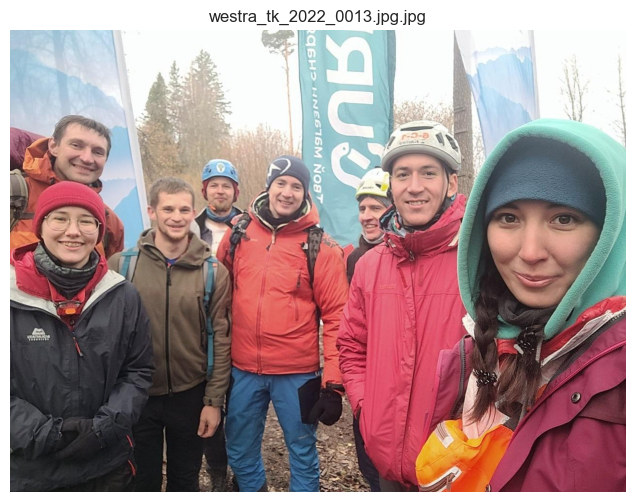

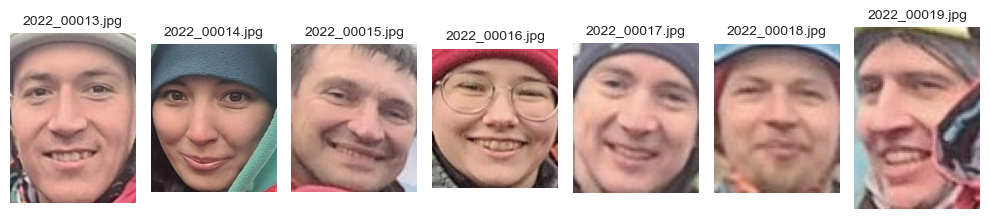

In [4]:
# пути
grp_p = f"data/raw/2022/westra_tk_2022_0013.jpg"
face_dir = f"data/faces_raw/2022"
faces = [os.path.join(face_dir, f"2022_{i:05d}.jpg") for i in (13, 14, 15, 16, 17, 18, 19)]
# групповой снимок
grp = cv2.imread(grp_p)
grp = cv2.cvtColor(grp, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(grp); plt.axis("off"); plt.title("westra_tk_2022_0013.jpg.jpg")
plt.show()

# вырезанные лица
plt.figure(figsize=(10, 4))
for i, p in enumerate(faces):
    f = cv2.imread(p)
    f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(1, 7, i + 1)
    ax.imshow(f); ax.axis("off"); ax.set_title(os.path.basename(p), fontsize=10)
plt.tight_layout(); plt.show()

### Первичный анализ по лицам

In [5]:
#Основные данные о участниках;
df_face = pd.read_csv(OUTPUT_CSV, sep=',', decimal='.')

#Категоризация (сортировка) признака эмоции.
emotion_order = ['fair', 'angry', 'sad', 'neutral', 'happy', 'surprise']
df_face["emotion"] = pd.Categorical(df_face["emotion"], categories=emotion_order, ordered=True)

df_face.sample(5)

,filename,face_number,gender,gender_score,emotion,emotion_score,age,analysis_time,folder,emotion_rank
106,2022_face_00106.jpg,107,Man,98.50,happy,100.00,37,2025-05-07 23:07:01,2022,5
2,2022_face_00002.jpg,3,Man,74.64,neutral,97.03,27,2025-05-07 23:06:11,2022,4
10,2022_face_00010.jpg,11,Man,99.86,sad,63.75,34,2025-05-07 23:06:15,2022,3
729,2024_face_00387.jpg,388,Woman,69.89,happy,100.00,46,2025-05-07 23:12:05,2024,5
450,2024_face_00108.jpg,109,Man,92.38,NaN,81.23,30,2025-05-07 23:09:53,2024,0


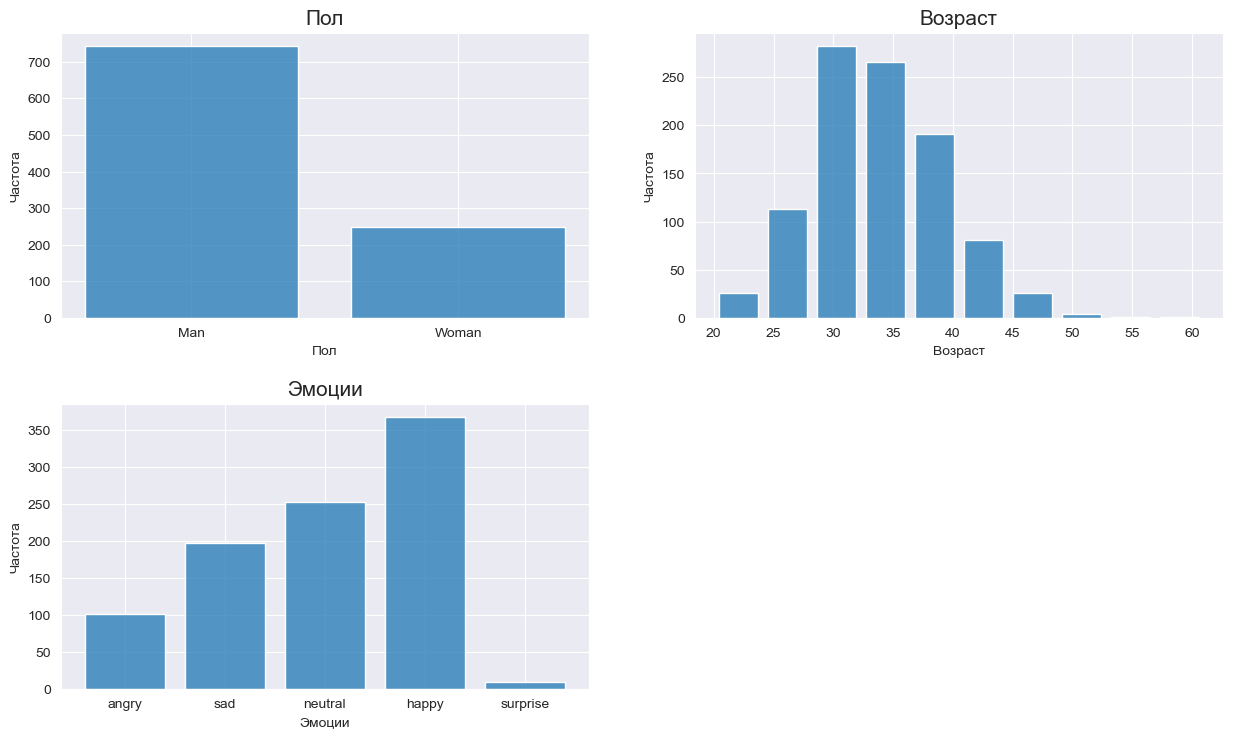

In [6]:
#Параметры для построения графиков
list_param = ['gender', 'age','emotion']
#Наименования параметров для построения графиков
list_name_param = ['Пол', 'Возраст', 'Эмоции']
#Заголовок листа
suptitle = ''

#Построение графиков
hist_graph (df_face,list_param,list_name_param , suptitle)

**Пол:** Аудитория преимущественно мужская — мужчин почти в 3 раза больше, чем женщин.

- **Возраст:** Основная возрастная группа — от 28 до 37 лет, с пиком на 30–34 года. Это активная взрослая аудитория.

- **Эмоции:** Преобладают нейтральные и позитивные (happy) выражения лиц, что говорит о комфортной атмосфере мероприятия. Негативные эмоции (angry, sad) встречаются значительно реже.

- **Общий вывод:** мероприятие собрало взрослую, преимущественно мужскую аудиторию с нейтрально-позитивным эмоциональным фоном.

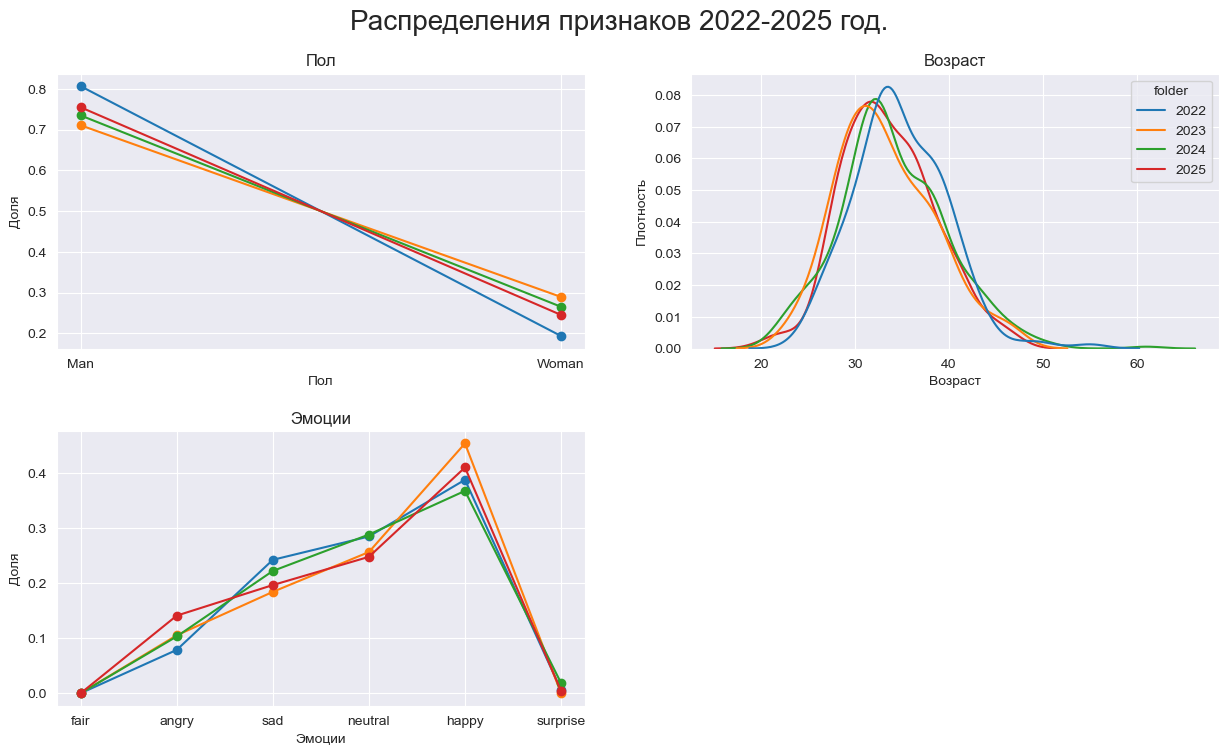

In [7]:
# Параметры
list_param      = ['gender', 'age', 'emotion']
list_name_param = ['Пол', 'Возраст', 'Эмоции']
suptitle        = 'Распределения признаков 2022-2025 год.'
p_hue           = 'folder'

# Сохраняем общий CSV
df_face.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")

# Строим графики
kde_graph(df_face, list_param, list_name_param, suptitle, p_hue)

**Короткий вывод по распределениям (2022–2025)**
- **Пол**: Доля мужчин стабильно превышает 70% во все годы. Небольшое снижение наблюдается в 2025 году.
  
- **Возраст**: Основная возрастная группа остаётся стабильной — 28–37 лет. В 2025 году наблюдается небольшое смещение в сторону более зрелой аудитории.

- **Эмоции**: Во все годы преобладают happy и neutral эмоции. В 2023 году больше всего выражений радости, в 2025 — слегка повышена доля «neutral» и «sad».

- **Общий вывод**: сообщество устойчиво привлекает взрослую мужскую аудиторию с позитивным или спокойным эмоциональным фоном, без резких изменений по годам.

**Тренды изменения аудитории по годам**

В этом блоке показана динамика средней оценки эмоций и возраста участников по годам (2022–2025). 
Для каждого года рассчитано:
- Среднее значение **emotion_rank** — числовой показатель, отражающий сдвиг от негативных к позитивным эмоциям.
- Средний **возраст** участников, определённый на основе распознанных лиц.

Графики позволяют увидеть, как меняется настроение и возрастная структура аудитории от года к году.


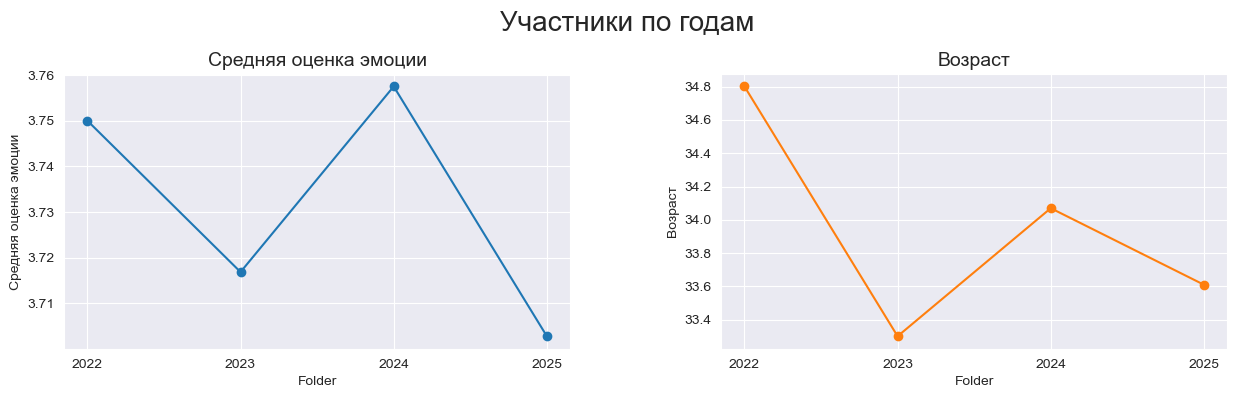

In [8]:
# словарь агрегаторов
agg_kwargs = {'emotion_rank':('emotion_rank', 'mean'),
              'age':('age', 'mean'),}

# словарь с кастомными заголовками
titles = {'emotion_rank':'Средняя оценка эмоции',
          'age':'Возраст',}

kde_graph_count (df_face, 'folder', agg_kwargs,  titles, 'Участники по годам')

- В 2024 году наблюдается **пик эмоционального подъёма** — наивысшее среднее значение по эмоциям.
- Самый молодой состав участников был в **2023 году**, а самый возрастной — в **2022**.
- В целом возраст аудитории держится в диапазоне **33–35 лет**, а эмоциональный фон — стабильно нейтрально-позитивный.


## Цифровой след: анализ текстов постов

### VK: посты по ключевому слову

На этом этапе проводится сбор и объединение текстового контента, связанного с мероприятием, из двух разных источников VK API:

1. **`wall.get`** — посты, опубликованные непосредственно в сообществе (уровень `root_post`);
2. **`newsfeed.search`** — пользовательские посты, в которых встречается заданное ключевое слово (уровень `user_post`).

Дополнительно выполняется:
- Фильтрация пользовательских постов по дополнительным ключевым словам `SUB_QUERY`;
- Исключение повторяющихся записей и постов самого сообщества;
- Расчёт совокупной метрики вовлечённости `reaction` (лайки + репосты + комментарии).


In [9]:
OWNER_ID =  next(iter(GROUPS.values()))
vk = vk_api.VkApi(token=TOKEN)

#  Запуск обоих методов
posts_wall = get_posts_wall(OWNER_ID, search_text=SEARCH_TEXT, start_time=START_TIME, end_time=END_TIME, limit=POSTS_LIMIT)
df_wall = to_dataframe(posts_wall)
df_wall['level'] = 'root_post'

posts_news = get_posts_newsfeed(SEARCH_TEXT, START_TIME, END_TIME, POSTS_LIMIT)
df_news = to_dataframe(posts_news)
df_news['level'] = 'user_post'

# Фильтрация по ключевым словам постов Уровня 2
pattern = r'\b(' + '|'.join(SUB_QUERY) + r')\b'
df_news = df_news[df_news['text'].str.contains(pattern, case=False, regex=True, na=False)]
df_news = df_news[df_news['owner_id']!=OWNER_ID]

# Объединение и удаление дублей
df_posts = pd.concat([df_wall, df_news], ignore_index=True)
df_posts['reaction'] = df_posts['likes'] + df_posts['reposts'] + df_posts['comments']

#  Вывод
print(f" wall.get: найдено {len(df_wall)}")
print(f" newsfeed.search (фильтровано по owner_id): найдено {len(df_news)}")
print(f" Объединено без дублей: {len(df_posts)}")
df_posts.head()

 wall.get: найдено 31
 newsfeed.search (фильтровано по owner_id): найдено 80
 Объединено без дублей: 111


,post_id,owner_id,date,year,month,text,views,likes,comments,reposts,post_url,level,reaction
0,5923,-403500,2025-04-28 19:00:01,2025,4,"🎉 ТГТ завершились, и мы наконец узнали результаты! 🎉 \n\nБудет много текста, потому что много победителей и призеров...",1969,82,1,11,https://vk.com/wall-403500_5923,root_post,94
1,5913,-403500,2025-04-24 18:00:02,2025,4,"Пока мы ждём итогов, давайте вспомним, как прошли соревнования ТГТ Вестры 2025!\n \n☀️Два насыщенных дня, солнечная ...",2215,76,1,1,https://vk.com/wall-403500_5913,root_post,78
2,5911,-403500,2025-04-22 11:15:28,2025,4,"Соревнования по ТГТ и ориентированию подошли к концу! 🎯🏆 \nА пока подсчитываются результаты, нам важно узнать ваше м...",1774,63,0,1,https://vk.com/wall-403500_5911,root_post,64
3,5904,-403500,2025-04-14 11:30:00,2025,4,🚀 До старта ТГТ Вестры 2025 остались считанные дни! \n \n🧭 Выкладываем условия проведения соревнований на дистанциях...,1849,43,3,2,https://vk.com/wall-403500_5904,root_post,48
4,5899,-403500,2025-04-02 18:15:00,2025,4,"🏔 ""ТГТ Вестра 2025"" – пора проверить свои силы на соревнованиях по технике горного туризма!\n\n📅 Даты: 19–20 апреля ...",2283,54,0,11,https://vk.com/wall-403500_5899,root_post,65


**Загрузка и объединение комментариев**

Чтобы получить более полное представление об активности и вовлечённости аудитории, на этом этапе к каждому посту загружаются комментарии с помощью метода `wall.getComments`.
Основные шаги:
- Для каждого поста из `df_posts` запрашиваются до 20 комментариев.
- Комментарии собираются в отдельный DataFrame `df_comments`, где каждому сообщению присваивается уровень `comment`.
- Дополнительно сохраняются метки времени, текст, количество лайков и ссылка на оригинальный пост.
- Затем все уровни (посты сообщества, посты пользователей, комментарии) объединяются в единый DataFrame `df_posts_full`.
  
Это создаёт основу для анализа диалогов, глубины обсуждения, эмоционального контекста и динамики взаимодействия с аудиторией.


In [10]:
#  Загрузка комментариев к каждому посту
def get_comments(owner_id, post_id, max_comments=20):
    try:
        response = vk.method('wall.getComments', {
            'owner_id': owner_id,
            'post_id': post_id,
            'count': max_comments,
            'preview_length': 0,
            'extended': 0
        })
        return response.get('items', [])
    except Exception as e:
        print(f" Ошибка получения комментариев для post_id={post_id}: {e}")
        return []

#  Сбор комментариев в датафрейм
comment_data = []

for _, row in df_posts.iterrows():
    comments = get_comments(row['owner_id'], row['post_id'])
    for c in comments:
        comment_data.append({
            'post_id': row['post_id'],
            'owner_id': row['owner_id'],
            'date': dt.datetime.fromtimestamp(c['date']),
            'year': dt.datetime.fromtimestamp(c['date']).year,
            'month': dt.datetime.fromtimestamp(c['date']).month,
            'text': c.get('text', ''),
            'views': None,
            'likes': c.get('likes', {}).get("count", 0),
            'comments': None,
            'reposts': None,
            'post_url': row['post_url'],
            'level': 'comment'  # Комментарии
        })

df_comments = pd.DataFrame(comment_data)
df_comments['reaction'] = df_comments['likes']  # пока только лайки

#  Объединяем
df_posts_full = pd.concat([df_posts, df_comments], ignore_index=True)

# Сохраняем общий CSV
df_posts_full.to_csv(OUTPUT_CSV_POST, index=False, encoding="utf-8")
print(f"\n Финальный CSV сохранён в {OUTPUT_CSV_POST}")

 Ошибка получения комментариев для post_id=3527: [212] Access to post comments denied
 Ошибка получения комментариев для post_id=2166: [212] Access to post comments denied
 Ошибка получения комментариев для post_id=326: [212] Access to post comments denied
 Ошибка получения комментариев для post_id=8572: [212] Access to post comments denied
 Ошибка получения комментариев для post_id=325: [212] Access to post comments denied
 Ошибка получения комментариев для post_id=2729: [212] Access to post comments denied

 Финальный CSV сохранён в dataset/analysis_post.csv


Анализируется цифрового отклика на мероприятие:
- **посты от сообщества** (`root_post`),
- и **пользовательские посты** (`user_post`), содержащие упоминания события.

Для каждого года и типа поста рассчитываются:
- Общее число просмотров и реакций (`sum`);
- Среднее число просмотров и реакций на один пост (`mean`).

Графики позволяют:
- сравнить динамику охвата и вовлечённости по годам;
- увидеть разницу между официальной и пользовательской активностью.

Это важный шаг для оценки органического интереса аудитории за пределами самого сообщества.

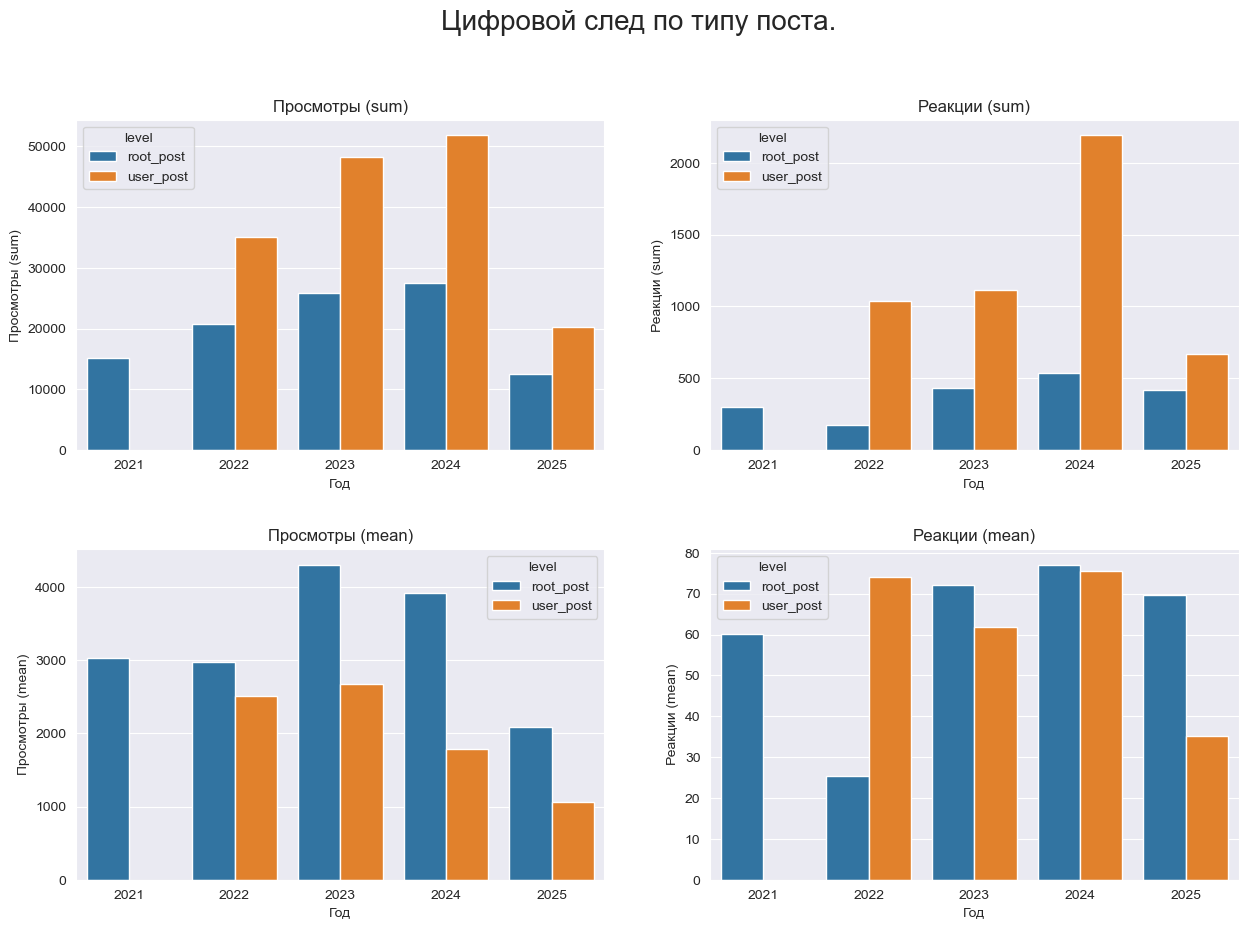

In [11]:
# Параметры
list_param      = ['views_s', 'reaction_s', 'views_m', 'reaction_m']
list_name_param = ['Просмотры (sum)', 'Реакции (sum)', 'Просмотры (mean)', 'Реакции (mean)']
suptitle        = 'Цифровой след по типу поста.'
x_n = 'year'
p_hue  = 'level'

df_pivot = df_posts_full[df_posts_full['level'].isin(['root_post', 'user_post'])].pivot_table(
    index=['year', 'level'],
    values=['views', 'reaction'],
    aggfunc={'views': ['mean', 'sum'], 'reaction': ['mean', 'sum']}
).reset_index()

df_pivot.columns = ['year', 'level', 'reaction_m' , 'reaction_s' , 'views_m' , 'views_s' ]
df_pivot.head()


#df_pivot = df_posts.pivot_table(index= [x_n, p_hue], values=list_param, aggfunc='sum').reset_index()

bar_graph (df_pivot, x_n, list_param,list_name_param, suptitle, p_hue  = 'level')

* **User-посты** стабильно показывают больший охват и вовлечённость, особенно в 2023–2024 годах — именно они обеспечили пик по просмотрам и реакциям.
* **Официальные посты (root\_post)** остаются стабильными по средним метрикам, но в 2025 году наблюдается снижение охвата и вовлечённости.
* В 2025 году общее падение всех показателей может свидетельствовать о спаде интереса или меньшем количестве событий.

**Вывод:** аудитория проявляет наибольшую активность при самостоятельном упоминании мероприятия, а не только в ответ на публикации сообщества. Поддержка пользовательского контента — ключевой драйвер вовлечённости.


### Inst: анализ по тегу

In [12]:
##### ===========================================================================
##### !!!! Возможность получать статистику с Instagram через библиотеку      !!!!
##### !!!! instaloader на территории РФ заблокирована на уровне провайдеров. !!!!
##### ===========================================================================

# import instaloader
# L = instaloader.Instaloader()

# USERNAME = "login"     # Введи имя пользователя Instagram
# PASSWORD = "passw"     # Введи пароль

# # Авторизация
# L.login(USERNAME, PASSWORD)

# # Сохраняем сессию, чтобы не логиниться заново в будущем
# L.save_session_to_file()

# hashtag = "тгт"
# posts = instaloader.Hashtag.from_name(L.context, hashtag).get_posts()

# data = []
# for post in posts:
#     data.append({
#         'date': post.date_utc,
#         'text': post.caption,
#         'likes': post.likes,
#         'comments': post.comments,
#         'shortcode': post.shortcode,
#         'url': f"https://www.instagram.com/p/{post.shortcode}/"
#     })
#     if len(data) > 100:  # ограничение на количество постов
#         break

# import pandas as pd
# df_ig = pd.DataFrame(data)
# df_ig.head()

### Эмоциональный фон постов и комментариев

** Анализ тональности постов и комментариев с помощью BERT**

Проводим автоматическую оценку **эмоциональной окраски текста** постов и комментариев.
Используется предобученная модель `blanchefort/rubert-base-cased-sentiment`, специально адаптированная под русский язык. 

Этот шаг позволяет количественно оценить эмоциональный фон обсуждения вокруг мероприятия и выявить, какие посты вызывают положительную или негативную реакцию.


In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

# Загружаем данные
df_sent = pd.read_csv(OUTPUT_CSV_POST)

# 1. Модель и токенизатор
model_name = 'blanchefort/rubert-base-cased-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# 2. Токенизация (сразу батч)
texts = df_sent['text'].fillna('').tolist()
tokens = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')

# 3. Предсказания
with torch.no_grad():
    outputs = model(**tokens)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1).numpy()

# 4. Сохраняем в DataFrame
df_sent['sentiment_label'] = np.argmax(probs, axis=1)
df_sent['sentiment_score'] = np.max(probs, axis=1)
df_sent['sentiment'] = df_sent['sentiment_label'].map({0: 'negative', 1: 'neutral', 2: 'positive'})

**Перевод оценки тональности в 9-балльную шкалу**    
Для более гибкого анализа эмоционального фона текстов проводится переход от 3-классовой модели (`negative`, `neutral`, `positive`) к **9-балльной шкале**.


In [14]:
# 1. Определим границы интервалов внутри каждой категории
sentiment_bounds = {}

for label in ['negative', 'neutral', 'positive']:
    subset = df_sent[df_sent['sentiment'] == label]['sentiment_score']
    if not subset.empty:
        min_score = subset.min()
        max_score = subset.max()
        bins = np.linspace(min_score, max_score, 4)  # 3 интервала = 4 границы
        sentiment_bounds[label] = bins

# 2. Присваиваем значения от 1 до 9 по интервалам
def map_sentiment_score(row):
    bins = sentiment_bounds.get(row['sentiment'])
    if bins is None:
        return np.nan

    idx = np.digitize(row['sentiment_score'], bins, right=False) - 1
    idx = max(0, min(2, idx))  # гарантируем, что будет от 0 до 2

    if row['sentiment'] == 'negative':
        return 1 + idx
    elif row['sentiment'] == 'neutral':
        return 4 + idx
    elif row['sentiment'] == 'positive':
        return 7 + idx

df_sent['sentiment_9scale'] = df_sent.apply(map_sentiment_score, axis=1)

# Сохраняем общий CSV
df_sent.to_csv(OUTPUT_CSV_POST, index=False, encoding="utf-8")
print(f"\n Финальный CSV сохранён в {OUTPUT_CSV_POST}")


 Финальный CSV сохранён в dataset/analysis_post.csv


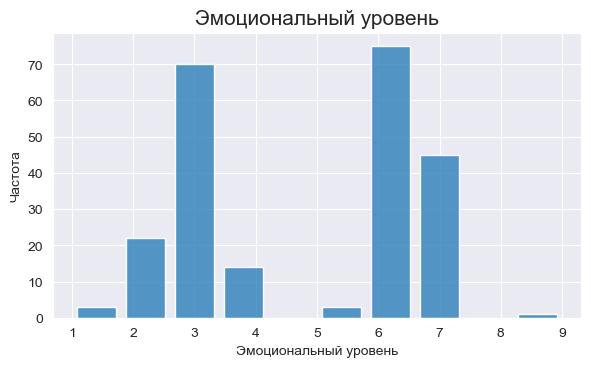

In [15]:
#Параметры для построения графиков
list_param = ['sentiment_9scale']
#Наименования параметров для построения графиков
list_name_param = ['Эмоциональный уровень']
#Заголовок листа
suptitle = ''
#Построение графиков
hist_graph (df_sent,list_param,list_name_param , suptitle)

#### Эмоциональный фон по типу постов

- `root_post` — посты, опубликованные сообществом;
- `user_post` — посты пользователей;
- `comment` — комментарии к постам.

9-балльная шкала позволяет тонко различать оттенки эмоций:
- от 1–3 (негатив),
- через 4–6 (нейтральные),
- до 7–9 (позитивные).

График помогает наглядно сравнить эмоциональную окраску текста в зависимости от источника: кто более эмоционален, кто сдержан, а кто чаще выражает позитив.


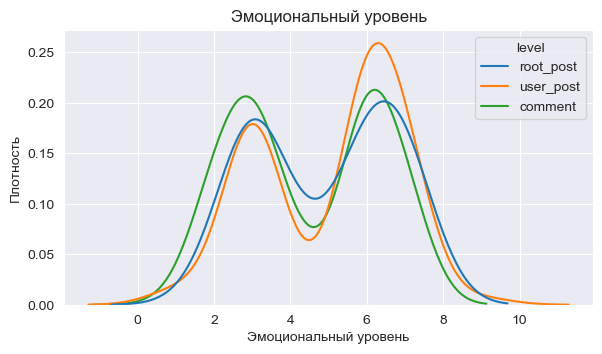

In [16]:
#Параметры для построения графиков
list_param = ['sentiment_9scale']
#Наименования параметров для построения графиков
list_name_param = ['Эмоциональный уровень']
#Заголовок листа
suptitle = ''
#Построение графиков
kde_graph (df_sent,list_param,list_name_param , suptitle, 'level')

User-посты чаще несут более эмоционально окрашенное содержание — сдвиг в сторону положительных оценок (7–9).

Комментарии в целом сбалансированы, но ближе к нейтрально-позитивной зоне.

Root-посты (официальные публикации сообщества) чаще интерпретируются моделью как менее эмоциональные и ближе к негативным (в диапазоне 2–4), что отражает их сдержанный, формальный стиль.

Важно: **модель не учитывает намерения, она опирается на языковую тональность.** Официальный стиль может восприниматься как "прохладный", даже если сообщение — нейтральное или позитивное по сути.

#### Сезонные тренды цифрового следа

На этом этапе анализируются **помесячные изменения цифровой активности** и эмоционального фона аудитории.

С помощью словаря агрегаторов рассчитываются:
- `Количество постов` — сколько публикаций появляется в каждый месяц;
- `Суммарные просмотры` — общий охват;
- `Суммарные реакции` — вовлечённость (лайки, репосты, комментарии);
- `Средний сентимент` — средний эмоциональный уровень постов (по 9-балльной шкале).

Графики позволяют выявить:
- В какие месяцы наблюдается всплеск активности или эмоционального подъёма;
- Есть ли сезонность или пики, связанные с проведением мероприятий;
- Как меняется настроение аудитории в течение года.


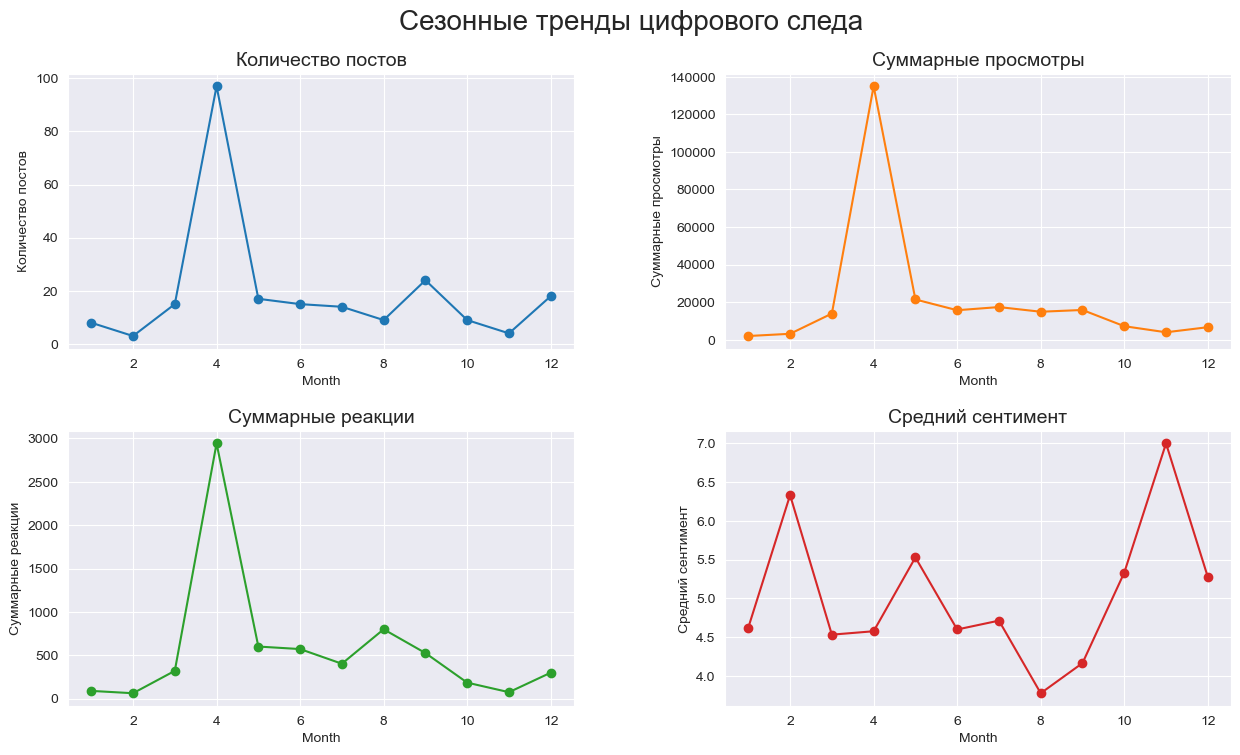

In [17]:
# словарь агрегаторов
agg_kwargs = {
    'post_count'    : ('year',            'size'),
    'views_sum'     : ('views',           'sum'),
    'reaction_sum'  : ('reaction',        'sum'),
    'sentiment_mean': ('sentiment_9scale','mean'),
}

# словарь с кастомными заголовками
titles = {
    'post_count'    : 'Количество постов',
    'views_sum'     : 'Суммарные просмотры',
    'reaction_sum'  : 'Суммарные реакции',
    'sentiment_mean': 'Средний сентимент'
}

kde_graph_count (df_sent, 'month', agg_kwargs,  titles, 'Сезонные тренды цифрового следа')

Апрель — отчётливый пик активности по всем метрикам: количество постов, просмотры, реакции. Вероятнее всего, в этом месяце проходит ключевое мероприятие.

После апреля активность заметно снижается, но локальные всплески наблюдаются в августе и ноябре.

Средний сентимент выше всего в феврале и ноябре–декабре, что может указывать на более тёплое или вдохновляющее содержание постов в эти месяцы.

Минимум по сентименту — август, где вероятно преобладает формальный или нейтральный стиль сообщений.

Вывод: цифровая активность и эмоциональный фон аудитории подвержены ярко выраженной сезонности, которую важно учитывать при планировании публикаций и событий.

#### Тренды цифрового следа по годам

В этом разделе агрегируются ключевые метрики цифровой активности по годам:

- **Количество постов** — динамика публикационной активности;
- **Суммарные просмотры** — общий охват контента;
- **Суммарные реакции** — лайки, репосты и комментарии в совокупности;
- **Средний сентимент** — средняя эмоциональная окраска текстов на основе 9-балльной шкалы.

Анализ годовых трендов позволяет выявить:
- периоды роста или спада интереса аудитории;
- эмоциональные сдвиги в подаче контента;
- влияние событийных или внешних факторов на поведение пользователей.

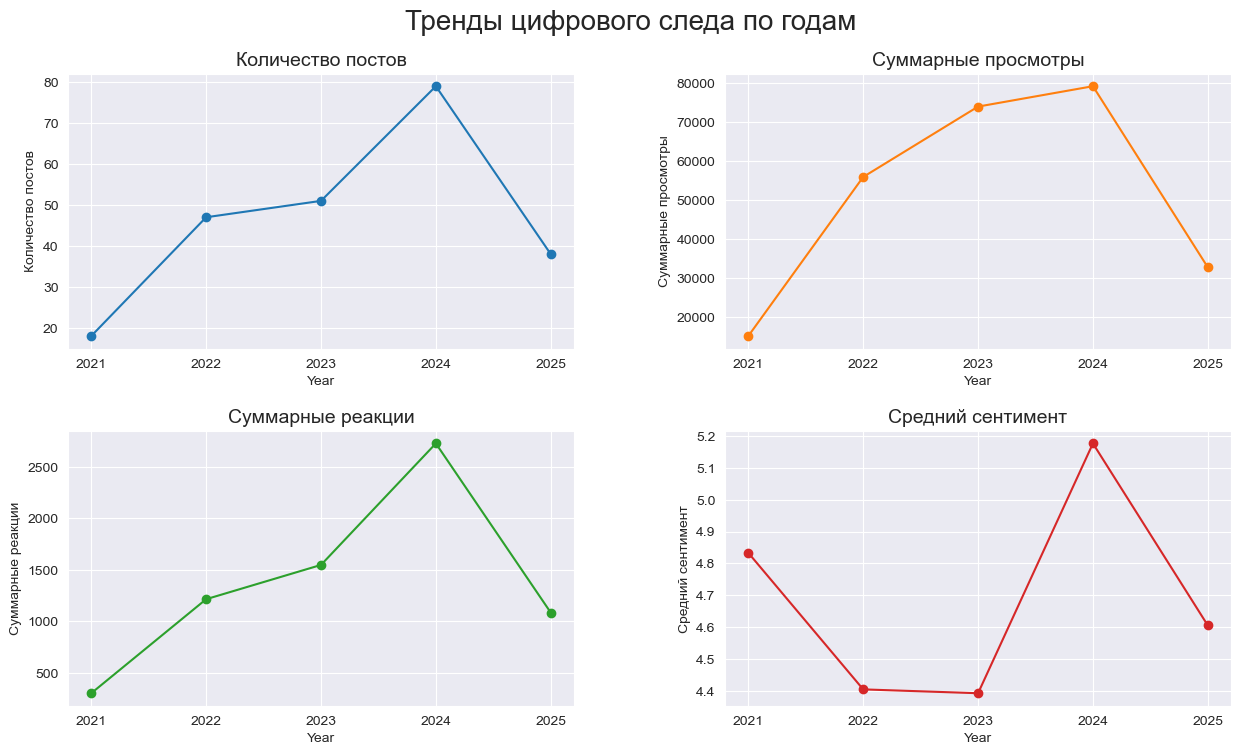

In [18]:
# словарь агрегаторов
agg_kwargs = {
    'post_count'    : ('year',            'size'),
    'views_sum'     : ('views',           'sum'),
    'reaction_sum'  : ('reaction',        'sum'),
    'sentiment_mean': ('sentiment_9scale','mean'),
}

# словарь с кастомными заголовками
titles = {
    'post_count'    : 'Количество постов',
    'views_sum'     : 'Суммарные просмотры',
    'reaction_sum'  : 'Суммарные реакции',
    'sentiment_mean': 'Средний сентимент'
}
kde_graph_count (df_sent, 'year', agg_kwargs,  titles, 'Тренды цифрового следа по годам')

### LDA - Тематический анализ постов

На этом этапе проводится тематическое моделирование текстов с использованием алгоритма **Latent Dirichlet Allocation (LDA)**, а также сопоставление обнаруженных тем с вручную заданными категориями (`theme_to_category`).
В результате мы получаем сводную таблицу с количеством постов по каждой теме и строится barplot-график "Преобладающая тематика".

Это позволяет:
- понять, какие темы чаще всего поднимаются в пользовательском и официальном контенте;
- автоматизировать присвоение категорий и рекомендаций на основе ключевых слов.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Doctor_PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Тема 1: место, спортивному, туризму, фото, время, люди, школы, участие
Тема 2: году, года, работы, очень, жизни, также, творчестве, января
Тема 3: место, участие, время, среди, монгуш, поход, который, студенты
Тема 4: соревнования, вестра, дистанция, школа, апреля, туризма, результаты, место
Тема 5: день, место, новое, города, club, первый, соревнования, туризма


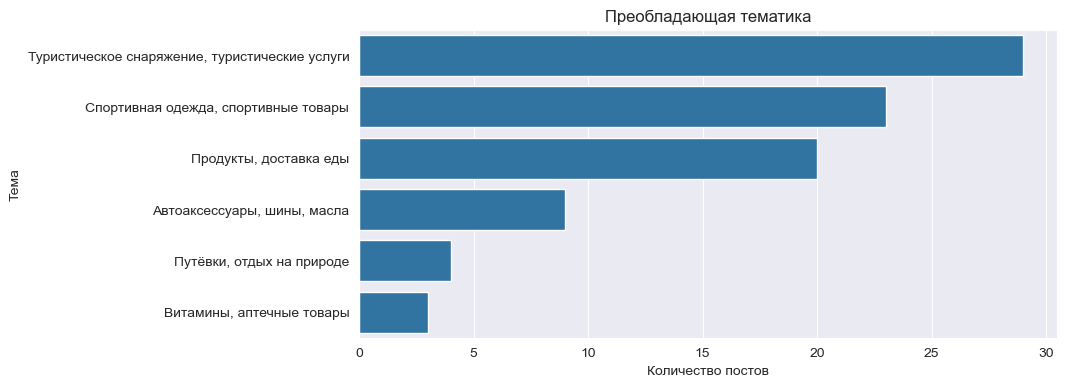

In [19]:
# 1. Загрузка данных 
df_post = pd.read_csv(OUTPUT_CSV_POST, encoding='utf-8')

# 2. Подготовка стоп-слов 
nltk.download('stopwords')
stop_words = set(stopwords.words('russian')) | set(stopwords.words('english'))

# 3. Инициализация токенизатора 
tokenizer = RegexpTokenizer(r'[а-яеa-z]+')  # включаем 'е' вместо 'ё'

# 4. Очистка и токенизация для LDA 
texts_clean = []
for raw in df_post['text'].dropna().astype(str):
    text = raw.lower().replace('ё', 'е')
    text = re.sub(r"http\S+|www\S+|[^а-яеa-z\s]", " ", text)
    tokens = tokenizer.tokenize(text)
    tokens = [tok for tok in tokens if tok not in stop_words and len(tok) > 3 and not tok.isdigit()]
    if tokens:
        texts_clean.append(tokens)

# 5. Создание словаря и корпуса
id2word = corpora.Dictionary(texts_clean)
id2word.filter_extremes(no_below=5, no_above=0.5)
corpus = [id2word.doc2bow(text) for text in texts_clean]

# 6. Обучение LDA-модели
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=5,
    random_state=42,
    passes=10
)

#  7. Сохранение тем LDA 
with open(OUTPUT_LDA_TOPICS, 'w', encoding='utf-8') as f:
    for topic_id in range(lda_model.num_topics):
        terms = lda_model.show_topic(topic_id, topn=8)
        words = [word for word, _ in terms]
        line = f"Тема {topic_id+1}: {', '.join(words)}"
        print(line)
        f.write(line + '\n')

def detect_theme(text):
    text = text.lower()
    return [kw for kw in theme_to_category if kw in text]

#  9. Классификация постов и сохранение результатов 
posts_data = []
# Используем индекс DataFrame как post_id, т.к. колонки 'id' нет
for idx, raw in df_post['text'].dropna().items():
    text = str(raw).lower()
    themes = detect_theme(text)
    for theme in themes:
        posts_data.append({
            'post_id': idx,
            'theme_detected': theme,
            'category_recommendation': theme_to_category[theme],
            'post_text_snippet': text[:100]
        })

# Создаём папку, если нужно
df_recommendations = pd.DataFrame(posts_data)
df_pivot_rec = df_recommendations.pivot_table(index=['category_recommendation', 'theme_detected',], values = 'post_id', aggfunc = 'count').sort_values ('post_id', ascending = False)

#Функция для построения графиков распределения в каждом из признаков .
#График распределения всех параметров по категориям
plt.figure(figsize=[9, 4])
sns.barplot(data=df_pivot_rec, x='post_id', y='category_recommendation')
plt.xlabel('Количество постов', fontsize="10")
plt.ylabel('Тема', fontsize="10")
plt.title('Преобладающая тематика', fontsize="12")
plt.show()

Короткий вывод по результатам LDA-анализa

- Наиболее часто встречающаяся тема — туристическое снаряжение и услуги, что отражает основной интерес аудитории к активному отдыху и подготовке к походам.

- Второе место — спортивная одежда и товары, что логично дополняет первую тематику.

- Значительное внимание также уделяется продуктам и доставке еды, особенно в контексте логистики мероприятий.

Вывод: LDA подтвердила, что контент сообщества в первую очередь связан с практическими потребностями активного отдыха: экипировка и туристическое питание.

In [20]:
# перекладываем в тему только те столбцы, которые нужны, и ставим post_id в индекс
theme_idx = df_recommendations.set_index('post_id')[['theme_detected','category_recommendation']]

# «лёгкий» join по индексу df_post и индексу theme_idx
df_post_full = df_post.join(theme_idx, how='left')

df_post_full.to_csv(OUTPUT_CSV_POST, index=False, encoding='utf-8-sig')
print(f" Сохранено в файл {OUTPUT_CSV_POST}")

 Сохранено в файл dataset/analysis_post.csv


#### Тематические тренды по годам.

На этом этапе проводится анализ, как **меняется интерес к темам** и связанный с ними **эмоциональный фон** в постах за период 2022–2025 гг.

Для каждого года строятся два распределения:
- по **темам**, выделенным с помощью ключевых слов (детектировано вручную или через LDA),
- по **эмоциональной окраске** (по шкале `sentiment_9scale`).

Сравнение этих графиков позволяет:
- выявить, какие темы доминируют в разные годы;
- отследить эмоциональные сдвиги внутри тематического поля (например, вызывает ли тема "доставка еды" больше негатива или позитива с течением времени);
- понять, как эволюционирует интерес аудитории и контентная подача внутри сообщества.


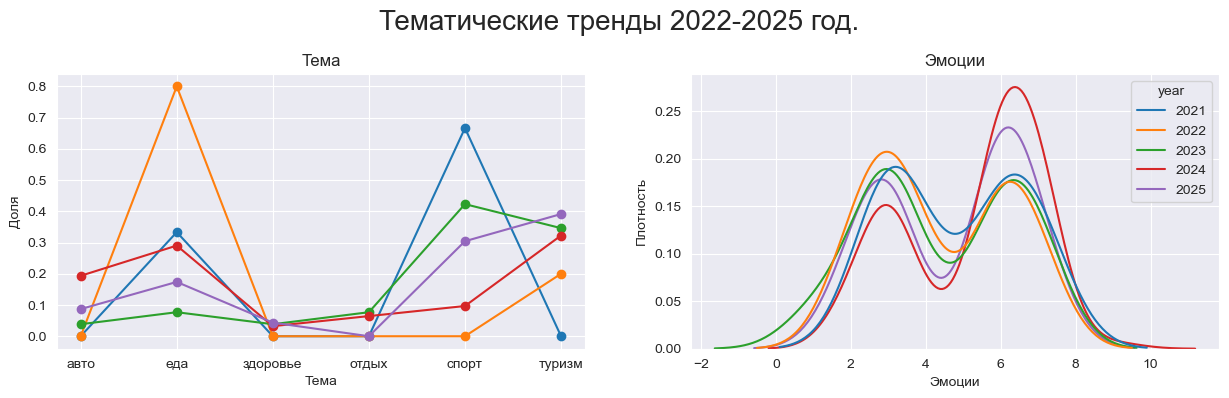

In [21]:
# Параметры
list_param      = ['theme_detected', 'sentiment_9scale']
list_name_param = ['Тема', 'Эмоции']
suptitle        = 'Тематические тренды 2022-2025 год.'
p_hue           = 'year'

# Строим графики
kde_graph(df_post_full, list_param, list_name_param, suptitle, p_hue)

**Вывод по тематическим трендам (2022–2025)**

В 2022 году наблюдается резкий всплеск интереса к теме еды — возможно, из-за изменения формата мероприятий или логистики.

Тематика спорта доминировала в 2021 году, но постепенно уступает место более прикладным направлениям: туризм, отдых, авто.

Эмоциональный фон сдвигается в сторону позитивных и нейтральных эмоций — пик распределения стабильно в районе 6–7 баллов по шкале.

2025 год — самый эмоционально приподнятый период за весь интервал, с наибольшей плотностью в позитивной зоне.

Вывод: интерес аудитории постепенно смещается от соревновательного контекста к бытовым и практическим темам, а общий эмоциональный настрой становится всё более позитивным.

## Итоговый вывод

### Общие вводные

В рамках проекта был проанализирован цифровой след соревнований по технике горного туризма (ТГТ), которые проводятся ежегодно в апреле с 2022 по 2025 год. Эти мероприятия собирают от 150 до 200 участников, представляя собой стабильное и хорошо организованное событие с узнаваемой повесткой.


### Фотографии и фотоанализ

Для анализа использовались публичные альбомы во «ВКонтакте» — от 550 до 1300 фотографий в каждом. После удаления дублирующих и нерелевантных изображений, объём выборки оказался в 5 раз больше, чем число участников, что позволило провести достоверный демографический и эмоциональный анализ.

Обработка \~3000 фотографий с помощью CPU i7-8700 заняла около 8 часов. Лица и эмбединги сохранялись отдельно, чтобы избежать повторных вычислений. Были реализованы фильтры для удаления мусорных снимков — визуальный контроль показал уровень ошибки не выше 5%.

Результаты:

* Гендерный состав: 71% мужчин и 29% женщин.
* Средний возраст: 33–34 года, ядро целевой аудитории — 25–44 года.
* Эмоциональный фон: преимущественно нейтрально-позитивный.
* Отрицательные эмоции (грусть, злость) наблюдаются не как реакция на событие, а как отражение напряжённых моментов соревнований.

Интересно, что с года в год эмоциональный фон остаётся стабильным, что подтверждает гипотезу о «консервативности» формата ТГТ: испытания и организационные паттерны повторяются, аудитория — постоянна.

### Посты, комментарии и цифровая активность

Для анализа использовались:

* посты в группах мероприятия;
* публичные посты участников;
* комментарии (в тех случаях, где был доступ);
* частично — сторис Telegram и попытка анализа Instagram (неудалась из-за ограничений в РФ).

Суммарная цифровая активность по годам:

* Просмотры: от 50 до 80 тысяч в год.
* Реакции: от 1.2 до 2.5 тысяч (конверсия 1.5–2%).
* Интересно, что посты от самих участников получают в 2 раза больше просмотров, чем публикации от лица группы.

 С 2022 по 2024 год наблюдался устойчивый рост активности. Однако в 2025 году зафиксирован спад. Если предположить наличие 5-летнего волнового цикла интереса к подобным мероприятиям, можно ожидать новый виток роста уже через 1–2 года.


### Тональность постов и комментариев

С помощью модели BERT (`blanchefort/rubert-base-cased-sentiment`) был проведён анализ тональности:

* Преобладают сдержанно-нейтральные и позитивные посты.
* Корневые публикации от групп — в официальном стиле (тональность \~3).
* Посты участников и комментарии чаще содержат позитив (\~6–7).
* Комментарии также часто несут эмоциональную окраску — благодарности, радость, переживания.

На шкале от 1 до 9 (расширенная градация на основе вероятности) большую часть занимают уровни 4–7, что соответствует умеренно-позитивной коммуникации.


### Тематики

Анализ тем с помощью BERTopic и SentenceTransformer выявил ключевые области интересов:

* Снаряжение и оборудование
* Туризм и спорт
* Еда и питание в походах

Эти тематики логично соотносятся с повесткой мероприятия и ожиданиями аудитории.

### Сезонность

Апрель — месяц пиковых значений как по числу постов, так и по реакции. Дополнительно выявлены два мини-пика:

* Ноябрь — время набора в школы туризма (рост позитивной коммуникации).
* Май-июнь — публикации фотоотчётов и «впечатлений после».

### Вывод по вовлечённости

Если проанализировать численность группы ВКонтакте и число активных взаимодействий (просмотры, лайки, комментарии, участие в соревнованиях), можно сделать вывод:

 **Активное ядро** сообщества — около 1000 человек (\~20% от численности группы).

Это те, кто участвуют в соревнованиях, походах, слётах, активно читают и комментируют контент. Именно с ними стоит работать точечно, выстраивая коммуникации и продвижение.

##  Рекомендации по развитию исследования

Чтобы сделать анализ ещё более точным и связать цифровой след с физическим участием:

1. **Геометки на фотографиях**
   Сбор координат позволит определить, какие эмоции чаще связаны с определёнными этапами соревнований или локациями. Например, больше радости — на финише, больше напряжения — у «параллельных перил».

2. **Офлайн-анкетирование**
   На старте или в конце соревнований можно предлагать заполнить короткую анкету: имя, ссылка на профиль ВК, возраст, род занятий. Это позволит привязать фотографии и посты к конкретным людям и сегментировать аудиторию точнее.

3. **Telegram**
   Развивать канал мероприятия с сохранением сторис, созданием чатов команд, сбором упоминаний по хештегу — это увеличит видимость и позволит обогатить данные анализа.

4. **Подключение аудио/видеоанализа**
   В будущем — анализ эмоций не только по фото, но и по голосу, фразам и выражениям лиц в видео.

## Вывод

События ТГТ — это стабильный, локально сильный формат. Он держит вовлечённую аудиторию, но требует периодического перезапуска интереса. Мы находимся у нижней точки цикла. Если следовать пятигодичному тренду, уже в ближайшие 1–2 года можно ожидать новый подъём.

В условиях роста интереса к активному отдыху, туризму и походному снаряжению, есть смысл начинать продвигать партнёрские бренды уже сейчас. Наиболее эффективные окна:

* **Ноябрь** — наборы в Школы горного туризма;
* **Апрель** — пик интереса во время мероприятия; всплеск эмоций и фотоконтента после.

Уровень позитивной вовлечённости и плотность сообщества позволяют использовать этот канал как основу для долгосрочной маркетинговой работы.
